In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('../')
import warnings;warnings.simplefilter('ignore')
from scripts import datasources, models, variables

In [4]:
county_dict = {
    'Alameda': '001', 'Contra Costa': '013', 'Marin': '041', 'Napa': '055', 'San Francisco': '075',
    'San Mateo': '081', 'Santa Clara': '085', 'Solano': '095', 'Sonoma': '097'
}

### Aggregate WLCM-assigned commute flows to the Census tract

In [5]:
orca.run(['initialize_network_small', 'initialize_network_walk'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [6]:
orca.broadcast('jobs', 'persons', cast_index=True, onto_on='job_id')

In [7]:
df_hh_geog = orca.merge_tables('persons', ['persons', 'households', 'units', 'buildings', 'parcels'])[['block_id']]

In [8]:
df_w_geog = orca.merge_tables('persons', ['persons', 'jobs', 'buildings', 'parcels'])[['block_id']]

In [9]:
ods = pd.merge(df_hh_geog, df_w_geog, left_index=True, right_index=True, suffixes=('_h', '_w'))

In [10]:
ods['tract_id_h'] = ods['block_id_h'].str[0:11]
ods['tract_id_w'] = ods['block_id_w'].str[0:11]

In [11]:
ods = ods[['tract_id_h', 'tract_id_w']]

In [12]:
od_counts = ods.reset_index().groupby(['tract_id_h', 'tract_id_w']).count().reset_index().rename(columns={'person_id': 'count'})

In [13]:
od_counts.sort_values('count', ascending=False).head()

,tract_id_h,tract_id_w,count
440599,06075061500,06075061500,1107
440442,06075061500,06075011700,1038
437900,06075060700,06075061500,750
437753,06075060700,06075011700,671
376049,06075017601,06075011700,426


In [14]:
len(od_counts)

804023

### Aggregate LODES data to the Census tract

In [31]:
lodes = pd.read_csv(
    'https://lehd.ces.census.gov/data/lodes/LODES7/ca/od/ca_od_main_JT01_2011.csv.gz',
    dtype={'w_geocode': str, 'h_geocode': str}, usecols=['w_geocode', 'h_geocode', 'S000'],
    compression='gzip')

In [85]:
lodes['tract_id_h'] = lodes['h_geocode'].str[0:11]
lodes['tract_id_w'] = lodes['w_geocode'].str[0:11]

In [93]:
lodes_tract_od_counts = lodes[['tract_id_h', 'tract_id_w', 'S000']].groupby(['tract_id_h', 'tract_id_w']).sum().reset_index().rename(columns={'S000': 'count'})

In [94]:
len(lodes_tract_od_counts)

4214164

### Merge WLCM results with LODES

In [95]:
merged = pd.merge(od_counts, lodes_tract_od_counts, on=['tract_id_h', 'tract_id_w'], suffixes=('_synth', '_lodes'))

In [96]:
len(merged)

381528

In [97]:
merged.head()

,tract_id_h,tract_id_w,count_synth,count_lodes
0,06001400100,06001400100,1,91
1,06001400100,06001400200,2,4
2,06001400100,06001400300,4,2
3,06001400100,06001400400,2,4
4,06001400100,06001400700,1,1


### Compare WLCM to LODES

In [149]:
merged['pct_diff'] = (merged['count_lodes'] - merged['count_synth'] / merged['count_lodes']) * 100

In [141]:
merged.sort_values('pct_diff').head()

,tract_id_h,tract_id_w,count_synth,count_lodes,pct_diff
31084,06001426100,06001422600,90,1,-89.0
25602,06001421600,06001422600,85,1,-84.0
42827,06001433103,06001432300,82,1,-81.0
27246,06001422500,06001422600,79,1,-78.0
18428,06001408100,06001432300,77,1,-76.0


Text(0.5,1,'Census Tract Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics')

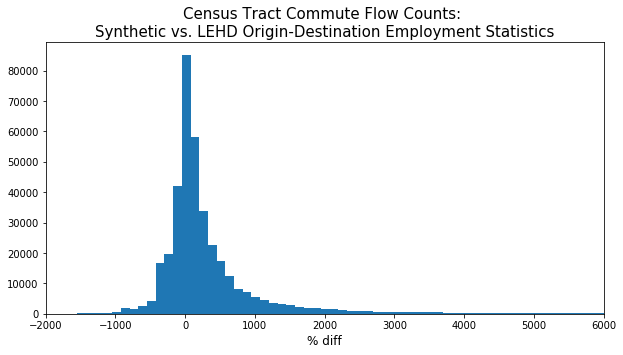

In [156]:
fig, ax = plt.subplots(figsize=(10,5))
_ = ax.hist(merged['pct_diff'], bins=1000)
ax.set_xlim(-2000, 6000)
ax.set_xlabel('% diff', fontsize=12)
ax.set_title('Census Tract Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)

Text(0.5,0,'LODES')

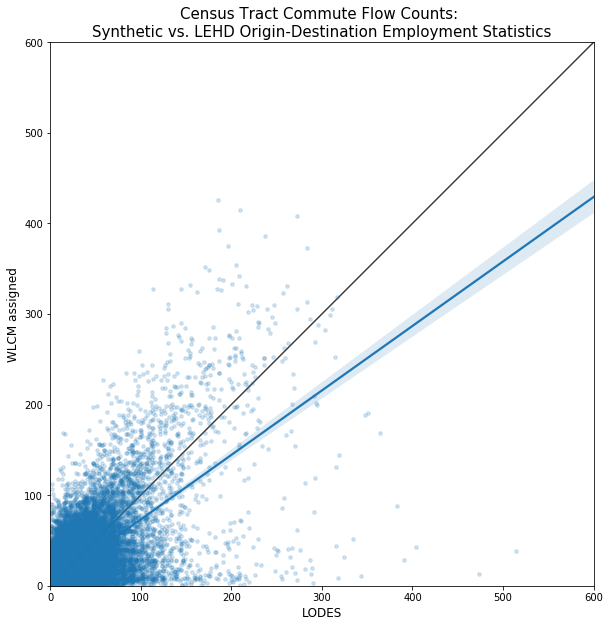

In [140]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(0, 600)
ax.set_ylim(0, 600)
sns.regplot(
    'count_lodes', 'count_synth', merged,#.sample(50000), 
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 50, "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Census Tract Commute Flow Counts: \nSynthetic vs. LEHD Origin-Destination Employment Statistics', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('LODES', fontsize=12)

### Load CTPP commute flows

In [90]:
ctpp = pd.read_csv('/home/data/Job_7201.csv', skiprows=2, dtype={'Workers 16 and Over': str})

In [91]:
ctpp = ctpp[ctpp['Output'] == 'Estimate']

In [117]:
ctpp['count_ctpp'] = ctpp['Workers 16 and Over'].str.replace(',', '').fillna(0).astype(int)

In [118]:
ctpp['tract_home'] = ctpp['RESIDENCE'].str.replace('.', '').str.extract('(\d+)')
ctpp['tract_home'] = ctpp['tract_home'].str.pad(6, 'right', '0')
ctpp['tract_work'] = ctpp['WORKPLACE'].str.replace('.', '').str.extract('(\d+)')
ctpp['tract_work'] = ctpp['tract_work'].str.pad(6, 'right', '0')

In [119]:
ctpp['county_name'] = ctpp['RESIDENCE'].str.split(',').str[1].str.strip().str.split(' ').str[0]

In [120]:
ctpp['county_code'] = ctpp['county_name'].map(county_dict)

In [121]:
ctpp['tract_id_h'] = '06' + ctpp['county_code'] + ctpp['tract_home']
ctpp['tract_id_w'] = '06' + ctpp['county_code'] + ctpp['tract_work']

In [122]:
ctpp.head()

,RESIDENCE,WORKPLACE,Output,Workers 16 and Over,Unnamed: 4,count_ctpp,tract_home,tract_work,county_name,county_code,tract_id_h,tract_id_w
0,"Census Tract 4001, Alameda County, California","Census Tract 4001, Alameda County, California",Estimate,165,NaN,165,400100,400100,Alameda,001,06001400100,06001400100
2,"Census Tract 4001, Alameda County, California","Census Tract 4002, Alameda County, California",Estimate,15,NaN,15,400100,400200,Alameda,001,06001400100,06001400200
4,"Census Tract 4001, Alameda County, California","Census Tract 4003, Alameda County, California",Estimate,10,NaN,10,400100,400300,Alameda,001,06001400100,06001400300
6,"Census Tract 4001, Alameda County, California","Census Tract 4004, Alameda County, California",Estimate,NaN,NaN,0,400100,400400,Alameda,001,06001400100,06001400400
8,"Census Tract 4001, Alameda County, California","Census Tract 4005, Alameda County, California",Estimate,NaN,NaN,0,400100,400500,Alameda,001,06001400100,06001400500


### Merge WLCM results with CTPP data

In [136]:
merged = pd.merge(
    od_counts, ctpp[['count_ctpp', 'tract_id_h', 'tract_id_w']],
    on=['tract_id_h', 'tract_id_w'], suffixes=('_synth', '_lodes')).rename(columns={'count': 'count_synth'})

In [137]:
len(merged)

3238968

In [140]:
merged = merged.fillna(0)

### Compare WLCM to CTPP

In [142]:
merged['pct_diff'] = (merged['count_ctpp'] - merged['count_synth'] / merged['count_ctpp']) * 100

In [143]:
merged['pct_diff'][merged['count_ctpp'] == merged['count_synth']] = 0

Text(0.5,1,'Census Tract Commute Flow Counts: \nSynthetic vs. CTPP')

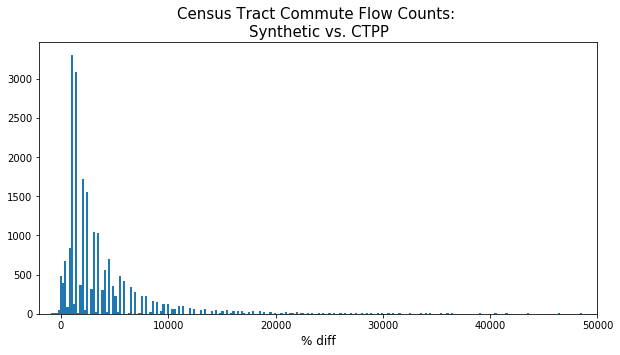

In [146]:
fig, ax = plt.subplots(figsize=(10,5))
_ = ax.hist(merged['pct_diff'][(merged['pct_diff'] > -1e10) & (merged['count_synth'] > 0)], bins=1000)
ax.set_xlim(-2000, 50000)
ax.set_xlabel('% diff', fontsize=12)
ax.set_title('Census Tract Commute Flow Counts: \nSynthetic vs. CTPP', fontsize=15)

Text(0.5,0,'CTPP')

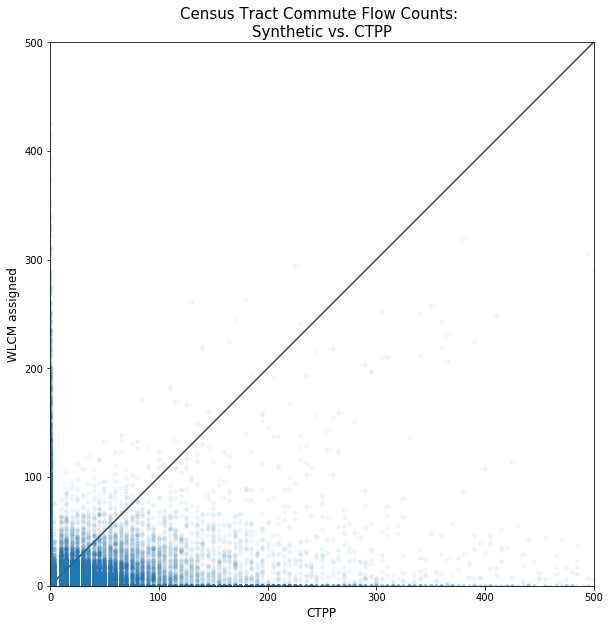

In [151]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
sns.regplot(
    'count_ctpp', 'count_synth', merged,#.sample(50000), 
    ax=ax, marker='.', fit_reg=False,
    scatter_kws={"s": 50, "alpha": 0.05})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('Census Tract Commute Flow Counts: \nSynthetic vs. CTPP', fontsize=15)
ax.set_ylabel('WLCM assigned', fontsize=12)
ax.set_xlabel('CTPP', fontsize=12)